# Marijuana Legalization and Violent Crime

Luopeiwen Yi

In recent years, many US states have decided to legalize the use of marijuana. 

When these ideas were first proposed, there were many theories about the relationship between crime and the "War on Drugs" (the term given to US efforts to arrest drug users and dealers over the past several decades). 

In this exercise, we're going to test a few of those theories using drug arrest data from the state of California. 

Though California has passed a number of laws lessening penalities for marijuana possession over the years, arguably the biggest changes were in  2010, when the state changed the penalty for possessing a small amount of marijuana from a criminal crime to a "civil" penality (meaning those found guilty only had to pay a fine, not go to jail), though possessing, selling, or producing larger quantities remained illegal. Then in 2016, the state fully legalized marijuana for recreational use, not only making possession of small amounts legal, but also creating a regulatory system for producing marijuana for sale. 

Proponents of drug legalization have long argued that the war on drugs contributes to violent crime by creating an opportunity for drug dealers and organized crime to sell and distribute drugs, a business which tends to generate violence when gangs battle over territory. According to this theory, with drug legalization, we should see violent crime decrease after legalization in places where drug arrests had previously been common. 

**To be clear,** this is far from the only argument for drug legalization! It is simply the argument we are well positioned to analyze today. 

(Students from Practical Data Science: This should sound familiar! Last semester we did this analysis in a very simple, crude manner; in this class we'll do it rigorously with your new found difference-in-differences skills!)

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from statsmodels.stats.power import TTestIndPower
import statsmodels.api as sm
from scipy import stats
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial
from plotnine import (
    ggplot,
    aes,
    geom_smooth,
    geom_vline,
    labs,
    xlab,
    ylab,
    scale_x_continuous,
    theme_bw,
    ggtitle,
    theme,
    element_blank,
    element_text,
)
from linearmodels import PanelOLS

warnings.filterwarnings("ignore")

pd.set_option("mode.copy_on_write", True)

## Exercise 1

Download and import California arrest data from [https://www.github.com/nickeubank/MIDS_Data/UDS_arrest_data.csv](https://www.github.com/nickeubank/MIDS_Data/UDS_arrest_data.csv). What is a unit of observation (a single row) in this data? What entities are being tracked, and over what time period? (This data is derived from raw California arrest data from the State Attorney General's office [here](https://openjustice.doj.ca.gov/data), in the "Arrests" category.)

Note that `VIOLENT` is a count of arrests for violent offenses, and `F_DRUGOFF` is a count of felony drug arrests. `total_population` is total population. 

In [2]:
cali_arrest = pd.read_csv(
    "https://media.githubusercontent.com/media/nickeubank/MIDS_Data/master/UDS_arrest_data.csv"
)

cali_arrest.head()

,YEAR,COUNTY,VIOLENT,F_DRUGOFF,total_population
0,1980,Alameda County,4504,3569,1105379.0
1,1981,Alameda County,4699,3926,1122759.3
2,1982,Alameda County,4389,4436,1140139.6
3,1983,Alameda County,4500,5086,1157519.9
4,1984,Alameda County,3714,5878,1174900.2


In [3]:
# Descriptive statistics for the dataset
descriptive_stats = cali_arrest.describe()
descriptive_stats

,YEAR,VIOLENT,F_DRUGOFF,total_population
count,2262.000000,2262.000000,2262.000000,2.262000e+03
mean,1999.000000,2084.767462,2063.761273,5.611930e+05
std,11.257117,5695.691031,5816.478130,1.297315e+06
min,1980.000000,1.000000,0.000000,1.097000e+03
25%,1989.000000,145.000000,109.000000,4.208128e+04
50%,1999.000000,516.000000,399.500000,1.525506e+05
75%,2009.000000,1925.500000,1498.250000,5.144530e+05
max,2018.000000,64790.000000,69667.000000,9.818605e+06


In [4]:
# Count unique values in the "COUNTY" column
unique_county_count = cali_arrest["COUNTY"].nunique()
print("Number of unique counties:", unique_county_count)

Number of unique counties: 58


>- The unit of observation is the data (count of arrests for violent offenses, count of felony drug arrests, and total population) for a specific county in California for a particular year. 
>- The entities being tracked are the 58 counties of California, and the time period covered range from 1980 to 2018.

## Exercise 2

In this analysis, we will split our sample into "treated" and "control" on the basis of whether a given county had a high average drug arrest rate in the three years before California began drug legalization in 2010. Counties with high drug arrest rates, after all, will be more impacted by drug liberalization policies. 

Calculate each county's average drug arrest *rate* for the period from 2007-2009. Then calculate the median value across counties, and create an indicator called `treated` for counties whose average drug arrest rate during this period was above the median average drug arrest rate. In other words, half your counties should be in the "treated" group, and half in "control". 

Note that this indicator should be *time-invariant*—if a county is in the treated group, it should always be identified as being in the treated group. 

In [5]:
# Calculate the average drug arrest rate
cali_arrest["drug_arrest_rate"] = (
    cali_arrest["F_DRUGOFF"] / cali_arrest["total_population"]
)

# Filter Data between 2007 and 2009
cali_arrest_3 = cali_arrest[cali_arrest["YEAR"].between(2007, 2009)]

# Calculate each county's average drug arrest rate for the period from 2007-2009
average_drug_arrest_county = (
    cali_arrest_3.groupby("COUNTY")["drug_arrest_rate"].mean().reset_index()
)
average_drug_arrest_county.head()

,COUNTY,drug_arrest_rate
0,Alameda County,0.003945
1,Alpine County,0.001976
2,Amador County,0.002890
3,Butte County,0.002717
4,Calaveras County,0.003122


In [6]:
# Calculate the median value across counties
median_average_drug_arrest_rate = average_drug_arrest_county[
    "drug_arrest_rate"
].median()

average_drug_arrest_county["treated"] = (
    average_drug_arrest_county["drug_arrest_rate"] > median_average_drug_arrest_rate
).astype(int)

average_drug_arrest_county.head()

,COUNTY,drug_arrest_rate,treated
0,Alameda County,0.003945,1
1,Alpine County,0.001976,0
2,Amador County,0.002890,0
3,Butte County,0.002717,0
4,Calaveras County,0.003122,1


In [7]:
# count unique values in treated to confirm a 50/50 split
average_drug_arrest_county["treated"].value_counts()

treated
1    29
0    29
Name: count, dtype: int64

In [8]:
# Select only COUNTY and treated columns for merging
average_drug_arrest_county_select = average_drug_arrest_county[["COUNTY", "treated"]]

In [9]:
print("I want to perform a left join on the two dataframes cali_arrest and")
print("average_drug_arrest_county_select on the column 'COUNTY'")

# Attempt the merge with validation
try:
    # The merge is expected to be many-to-one based on the assumptions
    cali_arrest_new = pd.merge(
        cali_arrest,
        average_drug_arrest_county_select,
        how="left",
        on="COUNTY",
        validate="m:1",
    )
    print("The type of merge is many to one.")
except Exception as e:
    print("The type of merge is not many to one:", e)
    pass

I want to perform a left join on the two dataframes cali_arrest and
average_drug_arrest_county_select on the column 'COUNTY'
The type of merge is many to one.


In [10]:
cali_arrest_new.head()

,YEAR,COUNTY,VIOLENT,F_DRUGOFF,total_population,drug_arrest_rate,treated
0,1980,Alameda County,4504,3569,1105379.0,0.003229,1
1,1981,Alameda County,4699,3926,1122759.3,0.003497,1
2,1982,Alameda County,4389,4436,1140139.6,0.003891,1
3,1983,Alameda County,4500,5086,1157519.9,0.004394,1
4,1984,Alameda County,3714,5878,1174900.2,0.005003,1


## Exercise 3

Our outcome in this analysis is the violent arrest rate -- if drug liberalization reduces crime overall, we would expect to see this rate fall in counties with high drug arrest rates after liberalization; if not, we would not expect to see any changes. Create a `violent_rate` variable with is violent arrests per 100,000 people. 

In [11]:
cali_arrest_new["violent_rate"] = (
    cali_arrest_new["VIOLENT"] / cali_arrest_new["total_population"]
) * 100000

cali_arrest_new.head()

,YEAR,COUNTY,VIOLENT,F_DRUGOFF,total_population,drug_arrest_rate,treated,violent_rate
0,1980,Alameda County,4504,3569,1105379.0,0.003229,1,407.462056
1,1981,Alameda County,4699,3926,1122759.3,0.003497,1,418.522474
2,1982,Alameda County,4389,4436,1140139.6,0.003891,1,384.952860
3,1983,Alameda County,4500,5086,1157519.9,0.004394,1,388.762215
4,1984,Alameda County,3714,5878,1174900.2,0.005003,1,316.111956


## Exercise 4

Differences-in-differences get their name from the fact that the estimator, in its most basic implementation, is just the difference between:

-  difference in the average change in outcome among eventually-treated units from before to after when treatment is applied, and
-  difference in the average change in outcome among never-treated units from before to after when treatment (to the treated units). 

(Obviously treatment is never a applied to the never-treated units -- when we talk about pre / post, we refer to before and after the point in time in which treatment is applied to the treated units. So if treated units are treated in 2008, then for the never-treated units, we are also comparing outcomes before 2008 to after 2008, even though 2008 has no special significance for the never-treated units). 

In its most basic implementation, therefore, calculating a difference-in-difference estimate requires calculating just 4 numbers:

- $\bar y_{T=1,Post}$  Avg for Treatment, Post-Treatment
- $\bar y_{T=0,Post}$  Avg for Control, Post-Treatment
- $\bar y_{T=1,Pre}$   Avg for Treatment, Pre-Treatment
- $\bar y_{T=0,Pre}$   Avg for Control, Pre-Treatment

The difference-in-differences estimator $\hat \delta$  is defined as

$$
\hat{\delta}= (\bar{y}_{T=1,\,Post}-\bar{y}_{T=1,\,Pre})-(\bar{y}_{T=0,\,Post}-\bar{y}_{T=0,\,Pre})
$$



Calculate (a) the change in violent arrest rates for our treated groups from before legalization to after ($\bar y_{T=1,Post} - \bar y_{T=1, Pre}$), and (b) our difference in difference estimator $\hat\delta$ by calculating these four values. Does doing your difference-in-difference estimate tell you something different from what you'd learn if you had just done a pre-post comparison?

For the `Pre` period, consider the three years before liberalization begins in 2010 (e.g. 2007-2009). For the `Post` period, consider the three years after final legalization took place (2016-2018). We will ignore the middle period in which marijuana was decriminalized but not yet legal. 

In [12]:
# Separate treatment and control group
cali_arrest_new_treated = cali_arrest_new[cali_arrest_new["treated"] == 1]
cali_arrest_new_control = cali_arrest_new[cali_arrest_new["treated"] == 0]

# Filter by years and calculate the average violent arrest rate for treated groups before legalization
average_violent_arrest_treated_before = (
    cali_arrest_new_treated[cali_arrest_new_treated["YEAR"].between(2007, 2009)]
    .groupby("COUNTY")["violent_rate"]
    .mean()
)

# Filter by years and calculate the average violent arrest rate for treated groups after legalization
average_violent_arrest_treated_after = (
    cali_arrest_new_treated[cali_arrest_new_treated["YEAR"].between(2016, 2018)]
    .groupby("COUNTY")["violent_rate"]
    .mean()
)

# Calculate the change in average violent arrest rates for treated
change_in_violent_arrest_treated = (
    average_violent_arrest_treated_after.mean()
    - average_violent_arrest_treated_before.mean()
)

# Filter by years and calculate the average violent arrest rate for control groups before legalization
average_violent_arrest_control_before = (
    cali_arrest_new_control[cali_arrest_new_control["YEAR"].between(2007, 2009)]
    .groupby("COUNTY")["violent_rate"]
    .mean()
)

# Filter by years and calculate the average violent arrest rate for control groups after legalization
average_violent_arrest_control_after = (
    cali_arrest_new_control[cali_arrest_new_control["YEAR"].between(2016, 2018)]
    .groupby("COUNTY")["violent_rate"]
    .mean()
)

# Calculate the change in average violent arrest rates for control
change_in_violent_arrest_control = (
    average_violent_arrest_control_after.mean()
    - average_violent_arrest_control_before.mean()
)

# Calculate the difference-in-differences estimator
diff_in_diff = change_in_violent_arrest_treated - change_in_violent_arrest_control

# Print results
print(
    f"The change in violent arrest rates for our treated groups from before"
    f" legalization to after is {change_in_violent_arrest_treated:.2f}"
)
print(
    f"The change in violent arrest rates for our control groups from before"
    f" legalization to after is {change_in_violent_arrest_control:.2f}"
)

print(f"Our difference in difference estimator is {diff_in_diff:.2f}")

The change in violent arrest rates for our treated groups from before legalization to after is -26.80
The change in violent arrest rates for our control groups from before legalization to after is -19.38
Our difference in difference estimator is -7.42


>- Doing difference-in-difference estimate tell me something different from what I've learn if I had just done a pre-post comparison. 
>- In the simple pre-post comparison of the treated group, the change in violent arrest rates for treated groups from before legalization to after is -26.80. In another word, the violent arrest rate has decreased by 26.8 (per 100,000 people) after legalization for the treated group. However, we are not sure if the entire decrease of violent arrest rate in the treated group is solely to the effect of marijuana legalization wihtout considering the control group.
>- However, our difference in difference estimator is -7.42. In another word, while both groups experienced a decrease in violent crime rates, the violent arrest rate has decreased by 7.42 (per 100,000 people) more after legalization for the treated group compared to the control group. 
>- Since the treated group's decrease in violent arrest rates was 7.42 (per 100,000 people) more than what would have been expected based on trends observed in the control group, the marijuana legalization had an impact on reducing violent crimes beyond general trends affecting the entire population.

## Exercise 5

Now calculate $\hat\delta$ using a regression with an indicator for post-2010, an indicator for treated, and an interaction of the two. Use only the same set of years you used above. How does your estimate compare to the estimate you calculated in Exercise 4?

What does this tell you about interpretation of interaction terms with two indicator variables?

Note: You need to cluster your standard errors by county, since we expect counties (over time) to be subject to common fluctuations. 

In [13]:
# subset to only include the pre and post years
cali_arrest_years = cali_arrest_new[
    cali_arrest_new["YEAR"].isin([2007, 2008, 2009, 2016, 2017, 2018])
]

cali_arrest_years.head()

,YEAR,COUNTY,VIOLENT,F_DRUGOFF,total_population,drug_arrest_rate,treated,violent_rate
27,2007,Alameda County,4443,6071,1490312.0,0.004074,1,298.125493
28,2008,Alameda County,4336,5893,1496965.0,0.003937,1,289.652731
29,2009,Alameda County,4318,5749,1503618.0,0.003823,1,287.174003
36,2016,Alameda County,3513,1762,1510271.0,0.001167,1,232.607261
37,2017,Alameda County,3965,1279,1510271.0,0.000847,1,262.535664


In [14]:
# Create the 'Post' indicator variable
cali_arrest_years["post"] = cali_arrest_years["YEAR"].apply(
    lambda x: 1 if x in [2016, 2017, 2018] else 0
)

# Create the interaction term
cali_arrest_years["Treated_Post"] = (
    cali_arrest_years["treated"] * cali_arrest_years["post"]
)

# Define the model formula
formula = "violent_rate ~ treated + post + Treated_Post"

# Fit the OLS model with clustered standard errors
model = smf.ols(formula, data=cali_arrest_years).fit(
    cov_type="cluster", cov_kwds={"groups": cali_arrest_years["COUNTY"]}
)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           violent_rate   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     11.00
Date:                Thu, 18 Apr 2024   Prob (F-statistic):           8.45e-06
Time:                        13:46:40   Log-Likelihood:                -2094.1
No. Observations:                 348   AIC:                             4196.
Df Residuals:                     344   BIC:                             4212.
Df Model:                           3                                         
Covariance Type:              cluster                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      319.7820     17.638     18.131      0.000     285.213     354.351
treated        106.8289     23.385      4.568      0.000      60.995     152.663
post           -19.3816      9.892     -1.959      0.050     -38.769       0.005
Treated_Post    -7.4181     18.869     -0.393      0.694     -44.401      29.565
==============================================================================
Omnibus:                       53.945   Durbin-Watson:                   0.741
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.621
Skew:                           0.965   Prob(JB):                     1.89e-18
Kurtosis:                       4.380   Cond. No.                         6.85
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [15]:
# Extract the coefficient for the interaction term directly
interaction_coefficient = model.params["Treated_Post"]
print(f"The coefficient for the interaction term is {interaction_coefficient:.2f}")

# Extract the p-value for the interaction term directly
interaction_pvalue = model.pvalues["Treated_Post"]
print(f"The p-value for the interaction term is {interaction_pvalue:.2f}")

The coefficient for the interaction term is -7.42
The p-value for the interaction term is 0.69


>- The coefficient of the interaction term with two indicator variables (Treated and Post_2010) is -7.42, which is the same as the diff-in-diff I calculated before. 
>- It indicates that after the legalization of marijuana, the violent arrest rate decreased by an additional 7.42 per 100,000 people in the treated group compared to the control group. However, the p-value of 0.69 suggests that this decrease is not statistically significant (p value > 0.05), implying that we cannot confidently attribute this reduction to the legalization itself. Therefore, this study does not provide statistically significant evidence to conclude that marijuana legalization reduces violent crimes beyond overall trends.

## Exercise 6

In the preceding exercise, we did a simple pre-post / treated-control comparison. But one important limitation of these designs is that they do not allow us to test for *parallel trends*. 

**Plot** a difference-in-difference model using data from 2000-2009 (inclusive) and from 2016-2018 (inclusive). Note this will have four different geometric components: a time trend for treated counties pre-2010, a time trend for control counties pre-2010, a time trend for treated counties post-2016 (include 2016), and a time trend for control counties post-2016 (include 2016). 

Do you see evidence of parallel trends for these two datasets? Does that make you feel more or less confident in your diff-in-diff estimates?

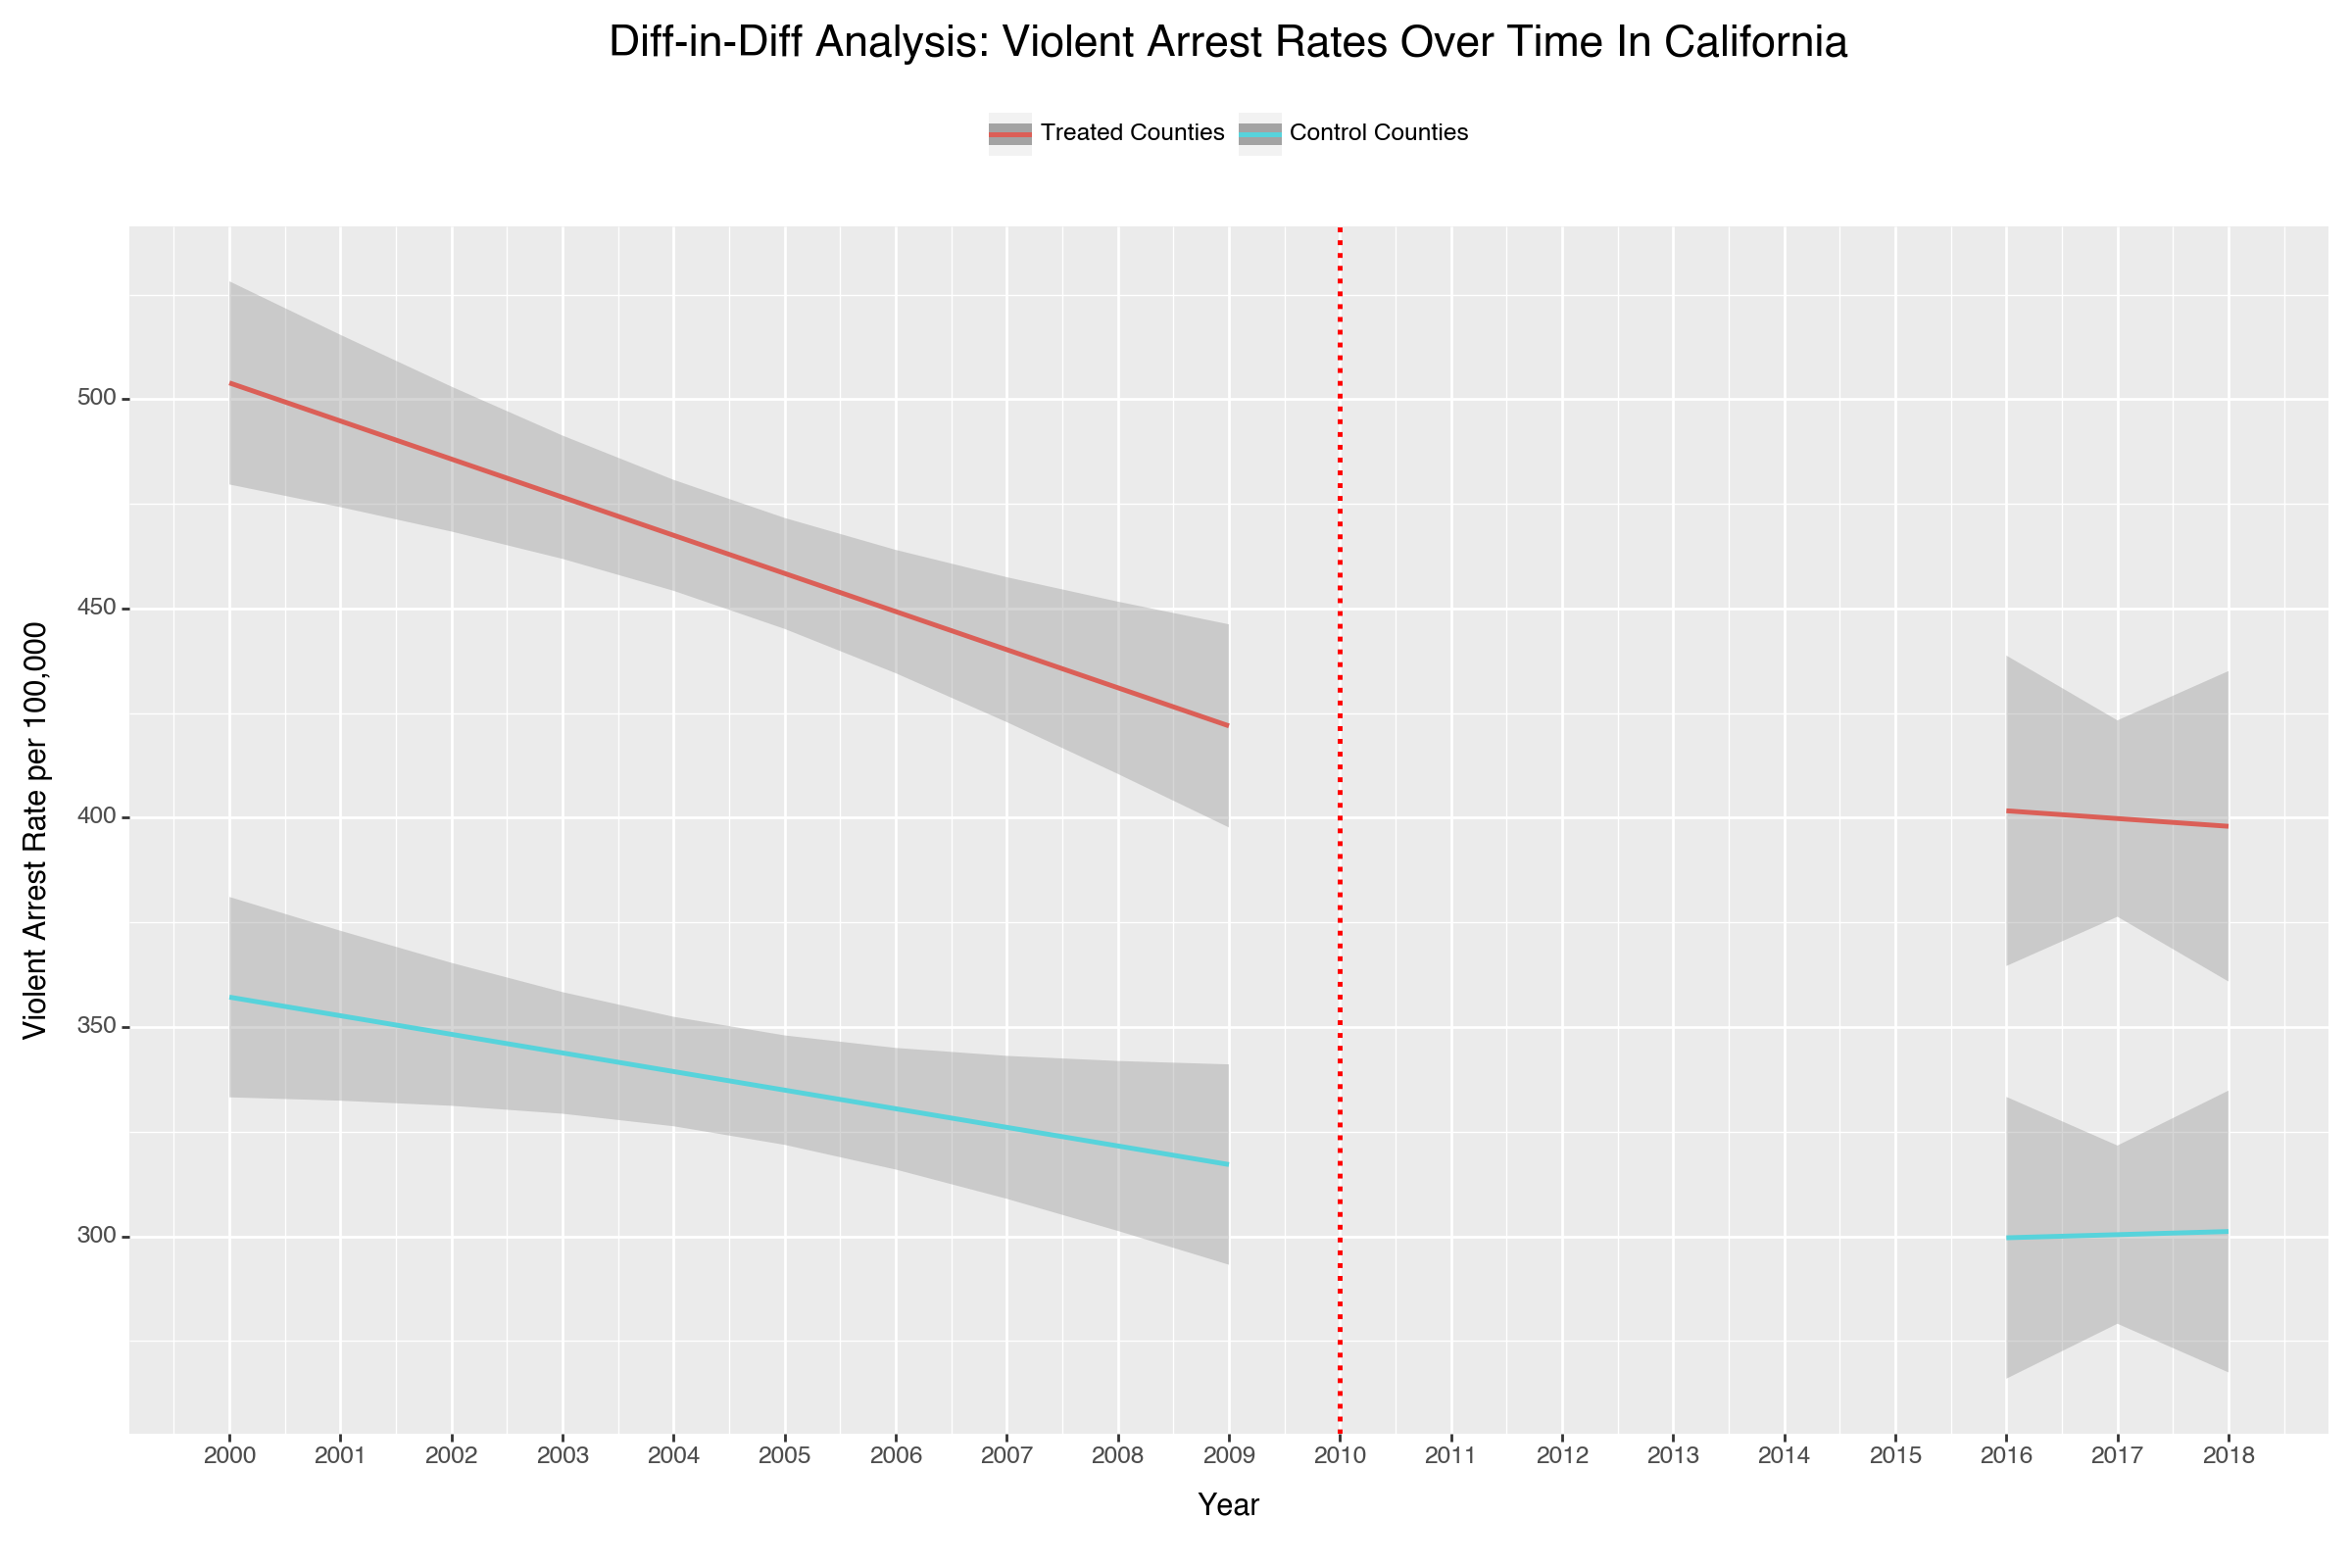

In [16]:
# Prepare data: Filter and separate into pre and post, and also by treated and control groups
df_pre_treated = cali_arrest_new[
    (cali_arrest_new["YEAR"] >= 2000)
    & (cali_arrest_new["YEAR"] <= 2009)
    & (cali_arrest_new["treated"] == 1)
]
df_pre_control = cali_arrest_new[
    (cali_arrest_new["YEAR"] >= 2000)
    & (cali_arrest_new["YEAR"] <= 2009)
    & (cali_arrest_new["treated"] == 0)
]
df_post_treated = cali_arrest_new[
    (cali_arrest_new["YEAR"] >= 2016)
    & (cali_arrest_new["YEAR"] <= 2018)
    & (cali_arrest_new["treated"] == 1)
]
df_post_control = cali_arrest_new[
    (cali_arrest_new["YEAR"] >= 2016)
    & (cali_arrest_new["YEAR"] <= 2018)
    & (cali_arrest_new["treated"] == 0)
]

# Create the plot using plotnine
plot = (
    ggplot()
    # Plot treated, pre-policy year
    + geom_smooth(
        df_pre_treated,
        aes(x="YEAR", y="violent_rate", color="'Treated Counties'"),
        method="lm",
    )
    # Plot control, pre-policy year
    + geom_smooth(
        df_pre_control,
        aes(x="YEAR", y="violent_rate", color="'Control Counties'"),
        method="lm",
    )
    # Plot treated, post-policy year
    + geom_smooth(
        df_post_treated,
        aes(x="YEAR", y="violent_rate", color="'Treated Counties'"),
        method="lm",
    )
    # Plot control, post-policy year
    + geom_smooth(
        df_post_control,
        aes(x="YEAR", y="violent_rate", color="'Control Counties'"),
        method="lm",
    )
    # Policy treatment line at 2010
    + geom_vline(xintercept=2010, linetype="dotted", color="red", size=1)
    # Labels and formatting
    + xlab("Year")
    + ylab("Violent Arrest Rate per 100,000")
    + labs(
        title="Diff-in-Diff Analysis: Violent Arrest Rates Over Time In California",
        color="Policy Period",
    )
    + scale_x_continuous(breaks=range(2000, 2019, 1))
    + theme(
        figure_size=(12, 8),  # Width and height of the plot in inches
        legend_position="top",
        legend_box="horizontal",
        legend_title=element_blank(),
        plot_title=element_text(size=16, ha="center"),  # Centered title
        legend_background=element_blank(),
    )
)

# Show the plot
print(plot)

>- The analysis of the pre-implementation period data reveals evidence of parallel decreasing trends in the violent arrest rates per 100,000 persons between the treated and control groups. Specifically, both groups show a consistent downward trajectory in the years leading up to the marijuana legalization policy implementation. Thus, it satisfies the parallel trends assumption of Diff-in-Diff. 
>- Given these parallel trends, I'm more confident that changes observed post-implementation are likely attributable to the policy intervention rather than being confounded by other external factors or pre-existing differentials in crime trends between the two groups. I'm more confident in my Diff-in-Diff estimates. 

## Exercise 7

While we can estimate the model described above precisely as a regression, it's actually much easier to estimate a more flexible model by running the regression we ran in Exercise 5 but with both `county` and `year` fixed effects. Use `PanelOLS` (or `lfe` in R) to estimate this fixed effects regression. 

With all these additional fixed effects, do you find evidence that marijuana legalization reduced violent crime?

In [17]:
cali_arrest_years = cali_arrest_years.set_index(["COUNTY", "YEAR"])

# Define the model with fixed effects
formula = "violent_rate ~ treated + post + Treated_Post + EntityEffects + TimeEffects"

# Fit the fixed effects model
model = PanelOLS.from_formula(formula, data=cali_arrest_years, drop_absorbed=True).fit(
    cov_type="clustered", cluster_entity=True
)

# Print the model summary
model.summary

Dep. Variable:,violent_rate,R-squared:,0.0013
Estimator:,PanelOLS,R-squared (Between):,-0.0109
No. Observations:,348,R-squared (Within):,0.0155
Date:,"Thu, Apr 18 2024",R-squared (Overall):,-0.0104
Time:,13:46:41,Log-likelihood,-1858.7
Cov. Estimator:,Clustered,,
,,F-statistic:,0.3829
Entities:,58,P-value,0.5366
Avg Obs:,6.0000,Distribution:,"F(1,284)"
Min Obs:,6.0000,,
Max Obs:,6.0000,F-statistic (robust):,0.1295


In [18]:
# Extract the coefficient for the interaction term directly
interaction_coefficient = model.params["Treated_Post"]
print(f"The coefficient for the interaction term is {interaction_coefficient:.2f}")

# Extract the p-value for the interaction term directly
interaction_pvalue = model.pvalues["Treated_Post"]
print(f"The p-value for the interaction term is {interaction_pvalue:.2f}")

The coefficient for the interaction term is -7.42
The p-value for the interaction term is 0.72


>- With all these additional fixed effects, I don't find evidence that marijuana legalization reduced violent crime since p value of the interaction term is 0.72 (p > 0.05)
>- The interaction term indicates that after the legalization of marijuana, the violent arrest rate decreased by an additional 7.42 per 100,000 people in the treated group compared to the control group. However, the p-value of 0.72 suggests that this decrease is not statistically significant (p value > 0.05), implying that we cannot confidently attribute this reduction to the legalization itself. Therefore, this study does not provide statistically significant evidence to conclude that marijuana legalization reduces violent crimes beyond overall trends.